Installing dependencies

In [1]:
!pip install torch==1.4.0 \
torchvision==0.5.0 -f https://download.pytorch.org/whl/cu101/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 753.4MB 11kB/s 
     |████████████████████████████████| 4.0MB 30.3MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


In [2]:
!pip install torch-geometric \
  torch-sparse==latest+cu101 \
  torch-scatter==latest+cu101 \
  torch-cluster==latest+cu101 \
  -f https://pytorch-geometric.com/whl/torch-1.4.0.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.4.0.html
     |████████████████████████████████| 215kB 4.2MB/s 
     |████████████████████████████████| 15.2MB 5.9MB/s 
     |████████████████████████████████| 10.6MB 49.8MB/s 
     |████████████████████████████████| 14.5MB 329kB/s 
     |████████████████████████████████| 235kB 7.1MB/s 
     |████████████████████████████████| 2.2MB 7.6MB/s 
     |████████████████████████████████| 51kB 152kB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.7.0-cp37-none-any.whl size=365386 sha256=a8008a6ea742926bbe1e2790f1cea3e8a5c5f3b777099075f65f9d5f4ef3a64b
  Stored in directory: /root/.cache/pip/wheels/ce/fb/df/37cd43d1433e65b2d3417a71438404d0eeb4fbbfa40730931c
Successfully built torch-geometric


Simple Graph

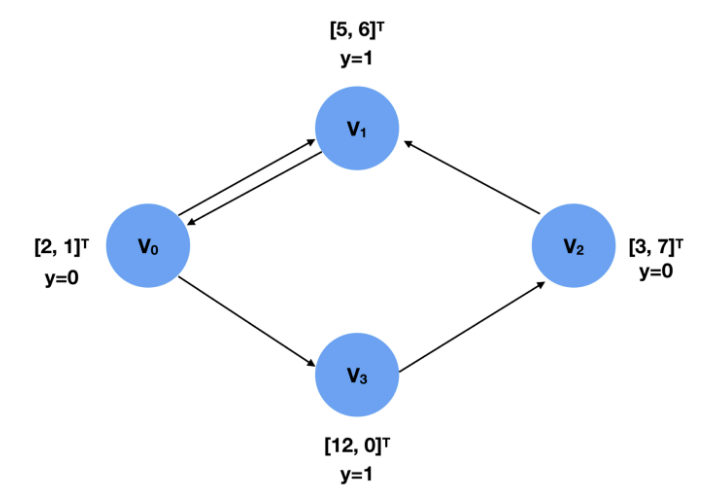

Creating a data object

In [3]:
import torch
from torch_geometric.data import Data

# Features - 
x = torch.tensor([[2, 1], 
                  [5, 6], 
                  [3, 7], 
                  [12, 0]], dtype = torch.float)

# Labels - 
y = torch.tensor([0, 1, 0, 1], dtype = torch.float)

# Adjacency matrix in the COO Format - Line 1 Source, Line 2 Dst
edge_index = torch.tensor([[0, 0, 1, 2, 3],
                           [1, 3, 0, 1, 2]], dtype = torch.long)

data = Data(x = x,
            y = y,
            edge_index = edge_index)

In [4]:
# Dataset in PyG - Example is of an InMemoryDataset

import torch
from torch_geometric.data import InMemoryDataset

class CustomDataset(InMemoryDataset):
  def __init__(self, 
               root,
               transform = None,
               pre_transform = None):
    super(CustomDataset, self).__init__(root,
                                        transform,
                                        pre_transform)
    self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
      return ['x', 'y', 'z']

    @property
    def processed_file_names(self):
      return ['data.pt'] 

    @property
    def download(self):
      pass

    @property
    def process(self):
      data_list = [...]

      if self.pre_filter is not None:
        data_list = [data for data in data_list if self.pre_filter(data)]

      if self.pre_transform is not None:
        data_list = [self.pre_transform(data) for data in data_list]

      data, slices = self.collate(data_list)
      torch.save((data, slices), self.processed_paths[0])
            

In [5]:
# Dataloader part - Sample

from torch.utils.data import DataLoader 

loader = DataLoader(dataset,
                    batch_size = 512,
                    shuffle = True)

for batch in loader:
  batch

NameError: ignored

## SAGEConv

In [6]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing 
from torch_geometric.utils import remove_self_loops, add_self_loops

class SAGEConv(MessagePassing):
  def __init__(self, in_channels, out_channels):
    super(SAGEConv, self).__init__(aggr = 'max')
    self.linear = nn.Linear(in_channels, out_channels)
    self.act = nn.ReLU()
    self.update_linear = nn.Linear(in_channels + out_channels,
                                   in_channels,
                                   bias = False)
    self.update_act = nn.ReLU()


  def forward(self, x, edge_index):
    '''
    Shape of x : [N, in_channels] 
    Shape of edge_index : [2, E]
    '''

    edge_index, _ = remove_self_loops(edge_index)
    edge_index, _ = add_self_loops(edge_index, num_nodes = x.size(0))
    return self.propagate(edge_index,
                          size = (x.size(0), x.size(0)),
                          x = x)

  def message(self, x_j):
    '''
    Shape of x_j : [E, in_channels] (Neighbours of x)
    '''

    x_j = self.linear(x_j)
    x_j = self.act(x_j)
    return x_j

  def update(self, aggr_out, x):
    '''
    Shape of aggr_out : [N, out_channels]
    '''

    embs = torch.cat([aggr_out, x], dim = 1)
    embs = self.update_act(self.update_linear(embs))
    return embs
     

## Applying to RecSys

id = https://drive.google.com/file/d/1PB8qyKwLHZ93Fi4Aw9z9moUvmNiRzx9g/view?usp=sharing

In [7]:
!pip install gdown
import gdown
url = 'https://drive.google.com/uc?id=1PB8qyKwLHZ93Fi4Aw9z9moUvmNiRzx9g'
output = 'yoochoose.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1PB8qyKwLHZ93Fi4Aw9z9moUvmNiRzx9g
To: /content/yoochoose.zip
434MB [00:02, 157MB/s]


'yoochoose.zip'

In [8]:
!unzip /content/yoochoose.zip

Archive:  /content/yoochoose.zip
   creating: yoochoose-data/
  inflating: yoochoose-data/yoochoose-buys.dat  
  inflating: yoochoose-data/yoochoose-clicks.dat  
  inflating: yoochoose-data/yoochoose-test.dat  
  inflating: yoochoose-data/dataset-README.txt  


In [9]:
import os
os.remove('/content/yoochoose.zip')

In [10]:
os.chdir('/content/yoochoose-data')

In [11]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

df = pd.read_csv('/content/yoochoose-data/yoochoose-clicks.dat', header = None)
df.columns = ['session_id', 'timestamp', 'item_id', 'category']

buys_df = pd.read_csv('/content/yoochoose-data/yoochoose-buys.dat', header = None)
buys_df.columns = ['session_id','timestamp','item_id','price','quantity']

item_encoder = LabelEncoder()
df['item_id'] = item_encoder.fit_transform(df.item_id)
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,session_id,timestamp,item_id,category
0,1,2014-04-07T10:51:09.277Z,2053,0
1,1,2014-04-07T10:54:09.868Z,2052,0
2,1,2014-04-07T10:54:46.998Z,2054,0
3,1,2014-04-07T10:57:00.306Z,9876,0
4,2,2014-04-07T13:56:37.614Z,19448,0


In [12]:
# Sampling as the dataset is HUGE
sample_ids = np.random.choice(df.session_id.unique(), 1000000,
                              replace = False)

df = df.loc[df.session_id.isin(sample_ids)]
df.nunique()

session_id    1000000
timestamp     3564324
item_id         35841
category          238
dtype: int64

In [13]:
# Ground Truth formation

df['label'] = df.session_id.isin(buys_df.session_id)
df.head()

,session_id,timestamp,item_id,category,label
10,3,2014-04-02T13:17:46.940Z,28989,0,False
11,3,2014-04-02T13:26:02.515Z,35310,0,False
12,3,2014-04-02T13:30:12.318Z,43178,0,False
38,13,2014-04-06T14:50:13.638Z,44324,0,False
39,13,2014-04-06T14:52:54.363Z,22423,0,False


In [14]:
# Dataset Creation

from tqdm import tqdm
import torch
from torch_geometric.data import InMemoryDataset

class YCDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(YCDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        return ['../input/yoochoose_click_binary_1M_sess.dataset']

    def download(self):
      pass

    def process(self):
        
        data_list = []

        # process by session_id
        grouped = df.groupby('session_id')
        for session_id, group in grouped:
            sess_item_id = LabelEncoder().fit_transform(group.item_id)
            group = group.reset_index(drop=True)
            group['sess_item_id'] = sess_item_id
            node_features = group.loc[group.session_id==session_id,['sess_item_id','item_id']].sort_values('sess_item_id').item_id.drop_duplicates().values

            node_features = torch.LongTensor(node_features).unsqueeze(1)
            target_nodes = group.sess_item_id.values[1:]
            source_nodes = group.sess_item_id.values[:-1]

            edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)
            x = node_features

            y = torch.FloatTensor([group.label.values[0]])

            data = Data(x=x, edge_index=edge_index, y=y)
            data_list.append(data)
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
            

In [ ]:
dataset = YCDataset(root='../')

In [ ]:
dataset = dataset.shuffle()
train_ds = dataset[:800000]
val_ds = dataset[800000:900000]
test_ds = dataset[900000:]

In [ ]:
# Model -----

from torch_geometric.nn import TopKPooling 
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn.functional as F

embed_dim = 128

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    
    self.conv1 = SAGEConv(embed_dim, 128)
    self.pool1 = TopKPooling(128, ratio = 0.8)
    self.conv2 = SAGEConv(128, 128)
    self.pool2 = TopKPooling(128, ratio = 0.8)
    self.conv3 = SAGEConv(128, 128)
    self.pool3 = TopKPooling(128, ratio = 0.8)  

    self.item_embedding = nn.Embedding(
        num_embeddings = df.item_id.max() + 1,
        embedding_dim = embed_dim
    )     

    self.linear1 = nn.Linear(256, 128) 
    self.linear2 = nn.Linear(128, 64) 
    self.linear3 = nn.Linear(64, 1) 

    self.bn1 = nn.BatchNorm1d(128)
    self.bn2 = nn.BatchNorm1d(64)
    self.act1 = nn.ReLU()
    self.act2 = nn.ReLU()


  def forward(self, data):
    x = data.x
    edge_index = data.edge_index
    batch = data.batch

    x = self.item_embedding(x).squeeze(1) 
    x = self.act1(self.conv1(x, edge_index))
    x, edge_index, _, batch, _ = self.pool1(x, edge_index, None, batch)
    x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim = 1) 

    x = self.act1(self.conv2(x, edge_index))
    x, edge_index, _, batch, _ = self.pool2(x, edge_index, None, batch)
    x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim = 1) 

    x = self.act1(self.conv3(x, edge_index))
    x, edge_index, _, batch, _ = self.pool3(x, edge_index, None, batch)
    x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim = 1)     

    x = x1 + x2 + x3

    x = self.act1(self.linear1(x))  
    x = self.act2(self.linear2(x))  
    x = F.dropout(x, 
                  p = 0.5, 
                  training=self.training)
    
    x = torch.sigmoid(self.linear3(x)).squeeze(1)
    return x


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-3)
criterion = nn.BCELoss()

In [ ]:
def train():
  model.train();

  loss_total = 0.
  for data in train_loader:
    data = data.to(device)
    optimizer.zero_grad()
    out = model(data)
    label = data.y.to(device)
    loss = criterion(out, label)
    loss.backward()
    loss_total += loss.item() * data.num_graphs
    optimizer.step()

  return loss_total / len(train_dataset)  

In [ ]:
from sklearn.metrics import roc_auc_score

def eval(loader):
  model.eval();
  preds = []
  labels = []

  with torch.no_grad():
    for data in loader:
      data = data.to(device)
      pred = model(data).detach().cpu().numpy()
      label = data.y.detach().cpu().numpy()
      preds.append(pred)
      labels.append(label)

  preds = np.hstack(preds)
  labels = np.hstack(labels) 

  score = roc_auc_score(preds, labels)
  return score   

In [ ]:
for epoch in range(1):
  loss = train()
  train_auc = eval(train_loader)
  val_auc = eval(val_loader)
  test_auc = eval(test_loader)
  print('Epoch: {:03d}, Loss: {:.5f}, Train Auc: {:.5f}, Val Auc: {:.5f}, Test Auc: {:.5f}'.
          format(epoch, loss, train_auc, val_auc, test_auc))